In [1]:
# encoding=utf8

import sys, os
import ephem
#import time, calendar
import matplotlib.pyplot as plt
#from matplotlib import animation
import cartopy.crs as ccrs
import numpy as np

r2d=180./np.pi

In [4]:
###
t0 = '2017/4/1 0:00'
sun = ephem.Sun()
#earth = ephem.Earth()
sun.compute(t0)
print(t0)
print('Apparent geocentric (right ascension, declination): %s %s' % (sun.ra, sun.dec))
print('Astrometric geocentric (right ascension, declination): %s %s' % (sun.a_ra, sun.a_dec))

###
line1='HIMAWARI-8'
line2='1 40267U 14060A   17120.00341436 -.00000294  00000-0  00000-0 0  9998'
line3='2 40267   0.0339  75.6694 0000630 345.5429 298.7960  1.00272895  9323'
hw = ephem.readtle(line1, line2, line3)
hw.compute('2017/4/23')
#hw.sublong
#Out[9]: 2.453493356704712
#hw.sublat
#Out[10]: -6.460651746920121e-08
#hw.sublong*180/3.1415
#Out[11]: 140.5789604350941

### create an observer
o = ephem.Observer()
o.lon = str(hw.sublong*180./np.pi)
o.lat = str(hw.sublat*180./np.pi)
o.elevation = 0.
o.date = t0
# o.date += ephem.Hour*12
sun.compute(o)
print('Sun: alt=%s az=%s earth_distance=%s m' % (sun.alt, sun.az, sun.earth_distance*ephem.meters_per_au))
hw.compute(o)
print('HW: alt=%s az=%s range=%s m' % (hw.alt, hw.az, hw.range))
#hwlon=repr(hw.sublong)
#hwlat=repr(hw.sublat)
class body():
    def __init__(self,lon,lat):
        # simple data holder that freezes locations
        self.lon=lon
        self.lat=lat
        return
hw2=body(hw.sublong,hw.sublat)
#hwlon=hw.sublong
#hwlat=hw.sublong
hw2.range=hw.range
print('HW: lon=%f lat=%f range=%s m' % (hw2.lon*r2d, hw2.lat*r2d, hw2.range))


###
T=1.; dt=1./4./24.
Nt=np.int(T/dt)
alt = np.zeros(Nt)
az = np.zeros(Nt)
ra = np.zeros(Nt)
dec = np.zeros(Nt)
earthd = np.zeros(Nt)
for i in range(Nt):
    #o.date = t0 + ephem.hour*dt*24.*i
    o.date += ephem.hour*dt*24.
    sun.compute(o)
    alt[i], az[i]=sun.alt, sun.az
    ra[i], dec[i]=sun.ra, sun.dec
    earthd[i] = sun.earth_distance*ephem.meters_per_au
t=np.arange(0.,T,dt)*24.

if False:
    plt.figure()
    plt.plot(t,alt*r2d,'k')
    plt.plot(t,az*r2d,'r')
    #plt.plot(ra,'b')
    #plt.plot(dec,'g')
    plt.grid()

    plt.figure()
    #plt.plot(alt,'k')
    #plt.plot(az,'r')
    plt.plot(t,ra*r2d,'b')
    plt.plot(t,dec*r2d,'g')

    plt.figure()
    plt.plot(t,earthd-earthd.mean(),'k')
    plt.title('earth distance, anomaly [m], mean=%e m'%earthd.mean(), fontsize=8)

    plt.show()



2017/4/1 0:00
Apparent geocentric (right ascension, declination): 0:42:07.63 4:31:47.0
Astrometric geocentric (right ascension, declination): 0:41:16.04 4:26:19.9
Sun: alt=49:23:21.2 az=83:01:58.1 earth_distance=149479874939.69263 m
HW: alt=89:18:22.3 az=270:08:16.1 range=35783312.0 m
HW: lon=139.985806 lat=0.001413 range=35783312.0 m


In [5]:

### computes the angle with respect to specular solar reflection
def get_vector(body):
    # in e_r, e_east, e_north basis
    return [np.sin(body.alt),np.cos(body.alt)*np.sin(body.az),np.cos(body.alt)*np.cos(body.az)]

def get_angle(v1,v2,acute=True):
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    if (acute == True):
        return angle
    else:
        return 2 * np.pi - angle

def angle2specular(body_sun,body):
    v_sun = get_vector(body_sun)
    v1 = get_vector(body)
    v1 = np.array(v1)+np.array(v_sun)
    v1 = v1/np.sqrt(v1[0]**2+v1[1]**2+v1[2]**2)
    # sun specular reflection:
    #v2 = [v_sun[0],-v_sun[1],-v_sun[2]]
    # normal
    v2 = [1.,0.,0.]
    return get_angle(v2,v1)

##
def get_sunzenith(sun,time):
    o = ephem.Observer()
    o.lon=0.
    o.lat=0.
    o.date=time
    o.elevation = 0.
    #
    sun.compute(o)
    v = get_vector(sun)
    sunlat=np.arcsin(v[2])
    sunlon= (np.arctan2(v[1],v[0])+o.lon)
    return sunlon*r2d, sunlat*r2d

##
def spherical2cartesian(v,lon,lat):
    # e_r,e_east,e_north to ex,ey,ez
    M = np.array([[np.cos(lat)*np.cos(lon), -np.sin(lon) , -np.sin(lat)*np.cos(lon)], \
                  [np.cos(lat)*np.sin(lon) , np.cos(lon), -np.sin(lat)*np.sin(lon)], \
                  [np.sin(lat) , 0., np.cos(lat)]])
    return M.dot(v)

def cartesian2spherical(v,lon,lat):
    # ex,ey,ez to e_r,e_east,e_north
    M = np.array([[np.cos(lat)*np.cos(lon), -np.sin(lon) , -np.sin(lat)*np.cos(lon)], \
                  [np.cos(lat)*np.sin(lon) , np.cos(lon), -np.sin(lat)*np.sin(lon)], \
                  [np.sin(lat) , 0., np.cos(lat)]])
    return M.transpose().dot(v)

def get_azalt(lon,lat,r,o):
    """ compute azimuth and altitude from lon/lat/range
    """
    v = r * np.array([np.cos(lon)*np.cos(lat),np.sin(lon)*np.cos(lat),np.sin(lat)]) # cartesian basis
    #print ephem.earth_radius # meters
    #print r
    v += -ephem.earth_radius*np.array([np.cos(o.lon)*np.cos(o.lat),np.sin(o.lon)*np.cos(o.lat),np.sin(o.lat)]) # substract observer position
    v = cartesian2spherical(v,o.lon,o.lat) # transform to spherical (er,eE,eN)
    #v = r*[np.sin(body.alt),np.cos(body.alt)*np.sin(body.az),np.cos(body.alt)*np.cos(body.az)]
    v = v/np.sqrt(v[0]**2+v[1]**2+v[2]**2)
    #print v
    alt = np.arcsin(v[0])
    az = np.arctan2(v[1],v[2])
    return az, alt



### debug
if False:
    print(np.array([[1.,2],[3,4],[5,6]]))
    print(np.array([[1.,2],[3,4],[5,6]]).dot([1,1]))

    print(spherical2cartesian([1.,0.,0.],0.*np.pi,0.*np.pi))  # ex
    print(spherical2cartesian([0.,1.,0.],0.*np.pi,0.*np.pi))  # ey
    print(spherical2cartesian([0.,0.,1.],0.*np.pi,0.*np.pi))  # ey
    print(spherical2cartesian([1.,0.,0.],0.5*np.pi,0.*np.pi)) # ey

    print(cartesian2spherical(spherical2cartesian([1.2,1.5,2.3],0.9*np.pi,0.2*np.pi),0.9*np.pi,0.2*np.pi))  # ex

if False:
    lon=0.9*np.pi
    lat=0.2*np.pi
    M = np.array([[np.cos(lat)*np.cos(lon), -np.sin(lon) , -np.sin(lat)*np.cos(lon)], \
                  [np.cos(lat)*np.sin(lon) , np.cos(lon), -np.sin(lat)*np.sin(lon)], \
                  [np.sin(lat) , 0., np.cos(lat)]],dtype=np.longdouble)
    print(M)
    print(M.dtype)
    print(M.transpose().dot(M))
    v = [1.2,1.5,2.3]
    print(M.dot(v))
    print(M.transpose().dot(M.dot(v)))
    
    
if True:
    t0 = '2017/4/1 0:00'
    o = ephem.Observer()
    o.lon = str(hw.sublong*180./np.pi)
    o.lat = str(hw.sublat*180./np.pi)
    o.elevation = 0.
    o.date = t0
    #az, alt = get_azalt(hw.sublong,hw.sublat,hw.range,o)
    az, alt = get_azalt(hw2.lon,hw2.lat,hw.range,o)
    #az, alt = get_azalt(o.lon,o.lat,hw.range,o)
    print('az=%f deg, alt=%f deg' %(az*r2d, alt*r2d))
    
    

az=-90.025121 deg, alt=90.000000 deg


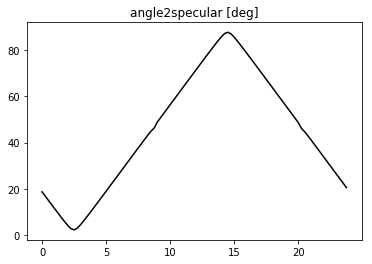

In [6]:
### plot angle to specular reflection

t0 = '2017/4/1 0:00'
o.date = t0
angle2spec = np.zeros(Nt)
for i in range(Nt):
    o.date += ephem.hour*dt*24.
    sun.compute(o)
    hw2.az, hw2.alt = get_azalt(hw2.lon,hw2.lat,hw2.range,o)    
    angle2spec[i] = angle2specular(sun,hw2)

plt.figure()
plt.plot(t,angle2spec*r2d,'k')
plt.title('angle2specular [deg]')

plt.show()

# default for bodies:
- a_ra — Astrometric geocentric right ascension for the epoch specified
- a_dec — Astrometric geocentric declination for the epoch specified
- g_ra and ra — Apparent geocentric right ascension for the epoch-of-date
- g_dec and dec — Apparent geocentric declination for the epoch-of-date
- elong — Elongation (angle to sun)
- mag — Magnitude
- size — Size (diameter in arcseconds)
- radius — Size (radius as an angle)
- circumpolar — whether it stays above the horizon
- neverup — whether is stays below the horizon

On Solar System bodies, also sets:
 
- hlon — Heliocentric longitude (see next paragraph)
- hlat — Heliocentric latitude (see next paragraph)
- sun_distance — Distance to Sun (AU)
- earth_distance — Distance to Earth (AU)
- phase — Percent of surface illuminated
Both hlon and hlat have a special meaning for the Sun and Moon. For a Sun body, they give the Earth’s heliocentric longitude and latitude. For a Moon body, they give the Moon’s geocentric longitude and latitude.

# for an observer:
Apparent topocentric position
- ra — Right ascension
- dec — Declination
 
Apparent position relative to horizon
- az — Azimuth east of north
- alt — Altitude above horizon

# unit vectors and angle computations:
vector basis: e_r, e_east, e_north

v_body = ($\sin(alt) , \cos(alt)\sin(az), \cos(alt)\cos(az)$)

v_normal = (1,0,0)

angle between two vectors: $\arccos \Big ( v_1 \cdot v_2 / |v_1||v_2|\Big )$


Nlon=80 , Nlat=80
Sun zenith location: lon=136.000000, lat=5.000000
Sun glint location: lon=138.000000, lat=2.000000


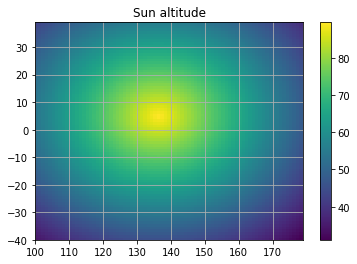

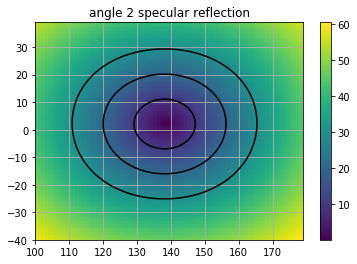

In [9]:
# define a domain
lon = np.arange(100.,180.,1.)
lat = np.arange(-40.,40.,1.)
LON,LAT=np.meshgrid(lon,lat)
Nlon=lon.size
Nlat=lat.size
print('Nlon=%d , Nlat=%d' %(Nlon,Nlat))


#print LON.shape
OB = [[ephem.Observer() for i in range(Nlon)] for j in range(Nlat)]
alt = np.zeros_like(LON)
az = np.zeros_like(LON)
angle2spec = np.zeros_like(LON)
for j in range(Nlat):
    for i in range(Nlon):
        OB[j][i].lon=str(LON[j,i])
        OB[j][i].lat=str(LAT[j,i])
        OB[j][i].elevation=0.
        OB[j][i].date = t0
        OB[j][i].date += ephem.hour*dt*24.*12.
        sun.compute(OB[j][i])
        #hw.compute(OB[j][i])
        hw2.az, hw2.alt = get_azalt(hw2.lon,hw2.lat,hw2.range,OB[j][i])
        alt[j,i], az[j,i] = sun.alt, sun.az
        angle2spec[j,i]=angle2specular(sun,hw2)

sunz = np.unravel_index(np.argmax(alt),alt.shape)
glint = np.unravel_index(np.argmin(angle2spec),angle2spec.shape)
print('Sun zenith location: lon=%f, lat=%f'%(LON[sunz],LAT[sunz]))
print('Sun glint location: lon=%f, lat=%f'%(LON[glint],LAT[glint]))

plt.figure()
plt.pcolormesh(lon,lat,alt*r2d)
plt.colorbar()
plt.grid()
plt.title('Sun altitude')

plt.figure()
plt.pcolormesh(lon,lat,angle2spec*r2d)
plt.colorbar()
lvls=np.arange(0., 40., 10.)
plt.contour(lon,lat,angle2spec*r2d,lvls,colors='k')
plt.grid()
plt.title('angle 2 specular reflection')


plt.show()

#print len(OB)
#print len(OB[0])







/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


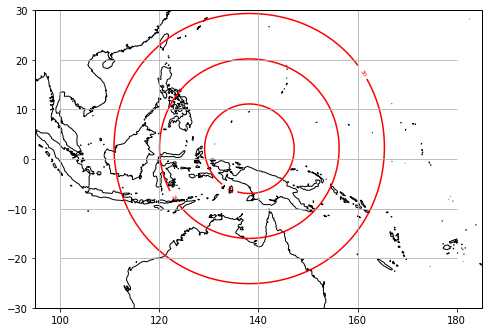

In [10]:
def plot_map(figsize=(8,6)):

    lonlim=[140.-45.,140.+45.]
    latlim=[-30., 30.]
    lon_tcks = np.arange(100.,200.,20.)
    lat_tcks = np.arange(-30.,40.,10.)

    plt.figure(figsize=figsize)
    ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.))
    ax.set_extent([lonlim[0], lonlim[1], latlim[0], latlim[1]],ccrs.PlateCarree())
    ax.set_xticks(lon_tcks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(lon_tcks.astype(int))
    ax.set_yticks(lat_tcks, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m') # Currently can be one of “110m”, “50m”, and “10m”
    ax.gridlines(xlocs=lon_tcks, ylocs=lat_tcks)
    
    return ax


### test drive
ax=plot_map()
lvls=np.arange(0., 40., 10.)
CS = ax.contour(lon,lat,angle2spec*r2d,lvls,colors='r', transform=ccrs.PlateCarree())
plt.clabel(CS, inline=1, fontsize=6, fmt='%d')
#plt.title('title', size=10) # to modify the title
#figname='figs/snapshot_'+vkey.replace (" ", "_")+'_magnitude.jpg'
#plt.savefig(figname, dpi=300)
#print figname+' printed'

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'figs/angle2specular.pdf'

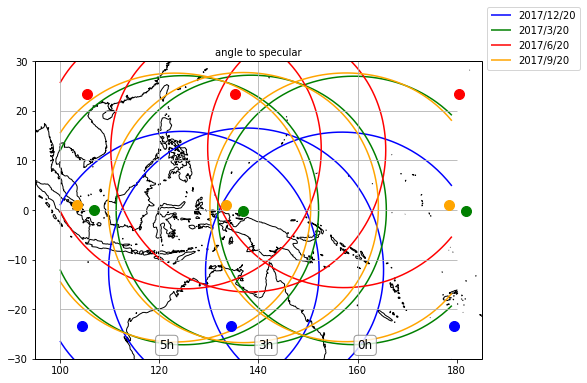

In [11]:
### 4 seasons, 3 hours
#t0 = '2017/m/1 h:00'
#M=[1,4,7,10]
t0 = '2017/m/20 h:00'
M=[12,3,6,9]
H=[0,3,5]
#
#t0 = '2017/m/1 h:30'
#H=[23,2,5]
cols=['b','g','r','orange']

# 360/24=15
# 3h -> 45deg
# 2.6h -> 40deg

ax=plot_map()
lvls=[30.]

OB = [[ephem.Observer() for i in range(Nlon)] for j in range(Nlat)]
CSleg=[]; labelsleg=[]
sun_ra = np.zeros((len(M),len(H))); sun_dec = np.zeros((len(M),len(H)))
sun_lon = np.zeros((len(M),len(H))); sun_lat = np.zeros((len(M),len(H)))
for im,m in enumerate(M):
    for ih,h in enumerate(H):
        t = t0.replace('m',str(m)).replace('h',str(h))
        sunalt = np.zeros_like(LON)
        sunaz = np.zeros_like(LON)
        hwalt = np.zeros_like(LON)
        hwaz = np.zeros_like(LON)        
        angle2spec = np.zeros_like(LON)
        for j in range(Nlat):
            for i in range(Nlon):
                OB[j][i].lon=str(LON[j,i])
                OB[j][i].lat=str(LAT[j,i])
                OB[j][i].elevation=0.
                OB[j][i].date = t
                sun.compute(OB[j][i])
                #hw.compute(OB[j][i])
                hw2.az, hw2.alt = get_azalt(hw2.lon,hw2.lat,hw2.range,OB[j][i])
                sunalt[j,i], sunaz[j,i] = sun.alt, sun.az
                hwalt[j,i], hwaz[j,i] = hw2.alt, hw2.az
                angle2spec[j,i] = angle2specular(sun,hw2)

        #CS = ax.contourf(lon,lat,sunalt*r2d, transform=ccrs.PlateCarree())
        #CS = ax.contourf(lon,lat,hwalt*r2d, transform=ccrs.PlateCarree())
        CS = ax.contour(lon,lat,angle2spec*r2d,lvls,colors=cols[im], transform=ccrs.PlateCarree())
        if ih==0:
            CSleg.append(CS.collections[0])
            labelsleg.append(t[:-5])
            
        sun_lon[im,ih], sun_lat[im,ih] = get_sunzenith(sun,t)
        ax.plot(sun_lon[im,ih],sun_lat[im,ih],'o',color=cols[im],markersize=10, transform=ccrs.PlateCarree())


plt.legend(CSleg, labelsleg,bbox_to_anchor=(1.0, 1.2),)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
#bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(120.,-28.,'%.0fh'%H[2],transform=ccrs.PlateCarree(),bbox=bbox_props,size=12)
ax.text(140.,-28.,'%.0fh'%H[1],transform=ccrs.PlateCarree(),bbox=bbox_props,size=12)
ax.text(160.,-28.,'%.0fh'%H[0],transform=ccrs.PlateCarree(),bbox=bbox_props,size=12)

#print sun_lon
#print sun_lat

plt.title('angle to specular', size=10) # to modify the title
figname='figs/angle2specular.pdf'
plt.savefig(figname, dpi=300)
plt.show()

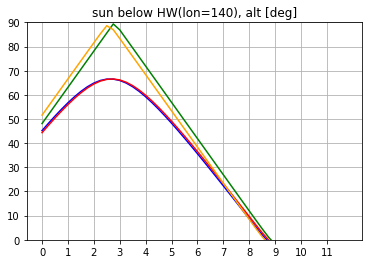

In [13]:
### play with sun zenith

#
### 4 seasons, 2 hours
t0 = '2017/m/1 0:00'
M=[1,4,7,10]
t0 = '2017/m/20 0:00'
M=[12,3,6,9]
cols=['b','g','r','orange']
T=0.5; dt=1./4./24.
t=np.arange(0.,T,dt)*24.

# 360/24=15
# 3h -> 45deg
# 2.6h -> 40deg
o = ephem.Observer()
o.lon = str(hw.sublong*180./np.pi)
o.lat = str(hw.sublat*180./np.pi)
o.elevation = 0.
alt=[]
az=[]
for im,m in enumerate(M):
    o.date = t0.replace('m',str(m))
    alt.append(np.zeros_like(t))
    az.append(np.zeros_like(t))
    for i in range(t.size):
        sun.compute(o)
        alt[im][i], az[im][i] = sun.alt, sun.az
        o.date += ephem.hour*dt*24.
        if im==0:
            sunlon, sunlat = get_sunzenith(sun,o.date)
            #print sunlon
    
   
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
for im,m in enumerate(M):
    ax.plot(t,alt[im]*r2d,color=cols[im])
#ax.plot(t,sunlon,color='k')
ax.set_ylim(0,90)
ax.set_xticks(np.arange(0,T*24.,1))
ax.set_yticks(np.arange(0,100,10))
ax.grid()
ax.set_title('sun below HW(lon=%0.f), alt [deg]'%(o.lon*r2d))

plt.show()


In [ ]:
### https://gis.stackexchange.com/questions/73728/how-do-i-convert-longitude-latitude-to-a-3d-geocentric-x-y-z-coordinate   
### http://jswhit.github.io/pyproj/
### http://www.satsleuth.com/GPS_ECEF_Datum_transformation.aspx
### https://en.wikipedia.org/wiki/Spherical_coordinate_system
### http://stackoverflow.com/questions/15937413/python-satellite-tracking-with-spg4-pyephem-positions-not-matching

#if you can use python, you can convert coordinates from WGS84 to geocentric coordinate 
#system (EPSG:4978) using this snippet of python code.

#import pyproj
#wgs84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')##4326
#geocentric= pyproj.Proj('+proj=geocent +datum=WGS84 +units=m +no_defs') ##4978
#x2 , y2  , z2= pyproj.transform( wgs84, geocentric, x, y, z)